# Feature Engineering & Cleaning – Emirates Reviews

Text Review Derived,Cleaned, feature-rich dataset with sentiments, emotions, topics, aspects, and imputed values  for modeling.


## Summary

This notebook transforms raw Emirates customer reviews into structured features for analysis.  
Key steps include:

- **Data loading & integration** of reviews with metadata.  
- **Sentiment & emotion modeling** using RoBERTa.  
- **Topic modeling** with BERTopic → reduced to interpretable clusters.  
- **Aspect feature engineering** (food, seat, staff, etc.) with aggregated sentiment scores.
- **Text cleaning** (stopwords, routes, airline terms).  
- **Missing value treatment** for numeric and categorical variables.  


# 1] Feature Engineering

- # Load Data

In [1]:
import pandas as pd

# File paths
ba_path = r"C:\Users\Samiksha\Documents\Dissertataion python\2BA_with_sentiment.csv"
em_path = r"C:\Users\Samiksha\Documents\Dissertataion python\2Em_with_sentiment.csv"

# Load datasets
ba_df = pd.read_csv(ba_path)
em_df = pd.read_csv(em_path)

# Quick check
print("British Airways dataset shape:", ba_df.shape)
print("Emirates dataset shape:", em_df.shape)
print("\nBA head:\n", ba_df.head())
print("\nEmirates head:\n", em_df.head())

British Airways dataset shape: (3218, 35)
Emirates dataset shape: (1475, 35)

BA head:
    overall_rating                              review_title review_date  \
0             1.0    "Service level far worse then Ryanair"  2023-11-19   
1             3.0  "do not upgrade members based on status"  2023-11-19   
2             8.0             "Flight was smooth and quick"  2023-11-16   
3             1.0             "Absolutely hopeless airline"  2023-11-16   
4             1.0        "Customer Service is non existent"  2023-11-14   

   verified_flag                                        review_text  \
0           True  4 Hours before takeoff we received a Mail stat...   
1           True  I recently had a delay on British Airways from...   
2          False  Boarded on time, but it took ages to get to th...   
3           True  5 days before the flight, we were advised by B...   
4          False  We traveled to Lisbon for our dream vacation, ...   

      travel_type    travel_class 

In [2]:
# Ensure the score columns are numeric
for df in [ba_df, em_df]:
    df["score_neg"] = pd.to_numeric(df["score_neg"], errors="coerce")
    df["score_neu"] = pd.to_numeric(df["score_neu"], errors="coerce")
    df["score_pos"] = pd.to_numeric(df["score_pos"], errors="coerce")

# Function to calculate weighted sentiment score (1–10 scale)
def calculate_sentiment_score(row):
    return (row["score_neg"] * 1) + (row["score_neu"] * 5) + (row["score_pos"] * 10)

# Apply to both datasets
ba_df["sentiment_score"] = ba_df.apply(calculate_sentiment_score, axis=1)
em_df["sentiment_score"] = em_df.apply(calculate_sentiment_score, axis=1)

# Preview
print(ba_df[["sentiment_label", "score_neg", "score_neu", "score_pos", "sentiment_score"]].head())
print(em_df[["sentiment_label", "score_neg", "score_neu", "score_pos", "sentiment_score"]].head())

  sentiment_label  score_neg  score_neu  score_pos  sentiment_score
0        negative   0.914841   0.076500   0.008660         1.383938
1        negative   0.915739   0.075835   0.008425         1.379170
2        positive   0.032338   0.243442   0.724220         8.491750
3        negative   0.865795   0.119305   0.014899         1.611316
4        negative   0.928247   0.063426   0.008327         1.328650
  sentiment_label  score_neg  score_neu  score_pos  sentiment_score
0        negative   0.955216   0.039250   0.005534         1.206808
1        negative   0.872006   0.113861   0.014134         1.582648
2        negative   0.969893   0.025812   0.004294         1.141898
3        negative   0.813181   0.168040   0.018779         1.841170
4        negative   0.848759   0.137728   0.013513         1.672531


In [3]:
# Count reviews per sentiment label for both datasets
print("British Airways sentiment counts:")
print(ba_df["sentiment_label"].value_counts())

print("\nEmirates sentiment counts:")
print(em_df["sentiment_label"].value_counts())

British Airways sentiment counts:
sentiment_label
negative    1884
positive    1031
neutral      303
Name: count, dtype: int64

Emirates sentiment counts:
sentiment_label
negative    892
positive    481
neutral     102
Name: count, dtype: int64


In [4]:
# Sentiment label counts
print("British Airways sentiment label counts:")
print(ba_df["sentiment_label"].value_counts(), "\n")

print("Emirates sentiment label counts:")
print(em_df["sentiment_label"].value_counts(), "\n")

# Sentiment score stats
print("British Airways sentiment score stats:")
print(ba_df["sentiment_score"].describe(), "\n")

print("Emirates sentiment score stats:")
print(em_df["sentiment_score"].describe())

British Airways sentiment label counts:
sentiment_label
negative    1884
positive    1031
neutral      303
Name: count, dtype: int64 

Emirates sentiment label counts:
sentiment_label
negative    892
positive    481
neutral     102
Name: count, dtype: int64 

British Airways sentiment score stats:
count    3218.000000
mean        4.576198
std         3.218698
min         1.077994
25%         1.682741
50%         3.218521
75%         8.026360
max         9.956078
Name: sentiment_score, dtype: float64 

Emirates sentiment score stats:
count    1475.000000
mean        4.564717
std         3.377137
min         1.074379
25%         1.651301
50%         2.888711
75%         8.504445
max         9.960575
Name: sentiment_score, dtype: float64


In [5]:
# Show all column names for both datasets
print("British Airways columns:")
print(list(ba_df.columns))

print("\nEmirates columns:")
print(list(em_df.columns))

British Airways columns:
['overall_rating', 'review_title', 'review_date', 'verified_flag', 'review_text', 'travel_type', 'travel_class', 'route', 'travel_date', 'seat_comfort', 'staff_service', 'ground_service', 'value_for_money', 'recommended', 'aircraft', 'food_quality', 'entertainment', 'wifi', 'airline', 'origin', 'destination', 'origin_raw', 'stopover_raw', 'destination_raw', 'origin_coords', 'stopover_coords', 'destination_coords', 'distance_km', 'flight_category', 'review_text_clean', 'sentiment_label', 'sentiment_confidence', 'score_neg', 'score_neu', 'score_pos', 'sentiment_score']

Emirates columns:
['review_title', 'review_date', 'verified_flag', 'aircraft', 'travel_type', 'travel_class', 'route', 'travel_date', 'seat_comfort', 'staff_service', 'food_quality', 'entertainment', 'wifi', 'ground_service', 'value_for_money', 'recommended', 'overall_rating', 'review_text', 'airline', 'origin', 'destination', 'origin_raw', 'stopover_raw', 'destination_raw', 'origin_coords', 'stop

In [6]:

# Convert to numeric, drop NaNs, cast to float
ba_df["overall_rating"] = pd.to_numeric(ba_df["overall_rating"], errors="coerce")
em_df["overall_rating"] = pd.to_numeric(em_df["overall_rating"], errors="coerce")

ba_df = ba_df.dropna(subset=["overall_rating"]).reset_index(drop=True)
em_df = em_df.dropna(subset=["overall_rating"]).reset_index(drop=True)

ba_df["overall_rating"] = ba_df["overall_rating"].astype(float)
em_df["overall_rating"] = em_df["overall_rating"].astype(float)

print("BA shape:", ba_df.shape)
print("EM shape:", em_df.shape)

BA shape: (3217, 36)
EM shape: (1475, 36)


- # Aspect Based Sentimental Analysis

- Cleaned and split reviews into sentences (removed airline/location words).  
- Ran BERTopic (Sentence-BERT + HDBSCAN + c-TF-IDF) to discover topics.  
- Grouped topics into service aspects (food, seat, staff, baggage, refunds, lounge, entertainment, cleanliness, airport service).  
- Built aspect keyword dictionaries from topic keywords.  
- Applied RoBERTa sentiment model to sentences (scores -1..+1).  
- Aggregated scores per aspect → structured features (`food_sentiment`, `seat_sentiment`, etc.) for each review.  

In [7]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from bertopic import BERTopic

# --------------------------
# Setup
# --------------------------
nltk.download("punkt")
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Custom stopwords: remove airline names & locations, but KEEP aspect words (seat, staff, food etc.)
custom_stopwords = set([
    "british", "airways", "ba", "emirates", "ek", "airline", "flight", "flights",
    "plane", "aircraft", "lufthansa", "klm", "qatar", "etihad",
    "heathrow", "gatwick", "dubai", "doha", "frankfurt", "paris", "london"
])
all_stopwords = stop_words.union(custom_stopwords)

# --------------------------
# Cleaning function
# --------------------------
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)  # keep digits (e.g., "777", "A380")
    words = [w for w in text.split() if w not in all_stopwords and len(w) > 2]
    return " ".join(words)

# --------------------------
# Sentence-level splitting + cleaning
# --------------------------
def preprocess_reviews(df, text_col="review_text"):
    sentences = []
    for review in df[text_col].dropna().tolist():
        for sent in sent_tokenize(review):
            cleaned = clean_text(sent)
            if len(cleaned.split()) > 3:  # keep meaningful sentences
                sentences.append(cleaned)
    return sentences

# Example: preprocess Emirates reviews
em_sentences = preprocess_reviews(em_df, text_col="review_text")

# --------------------------
# Fit BERTopic
# --------------------------
topic_model = BERTopic(
    language="english",
    calculate_probabilities=True,
    verbose=True,
    min_topic_size=30,   # avoid tiny clusters
    nr_topics="auto"     # merge similar clusters
)

topics, probs = topic_model.fit_transform(em_sentences)

# --------------------------
# Inspect topics
# --------------------------
print("\nTop topics:")
print(topic_model.get_topic_info().head(20))

# Inspect a few sample reviews per topic
for topic in topic_model.get_topic_info().head(5)["Topic"]:
    print(f"\n--- Topic {topic} ---")
    print(topic_model.get_topic(topic))  # top words
    example_indices = [i for i, t in enumerate(topics) if t == topic][:3]
    for idx in example_indices:
        print(">>", em_sentences[idx])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Samiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-08-26 01:00:11,646 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/369 [00:00<?, ?it/s]

2025-08-26 01:02:02,604 - BERTopic - Embedding - Completed ✓
2025-08-26 01:02:02,604 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-26 01:03:32,464 - BERTopic - Dimensionality - Completed ✓
2025-08-26 01:03:32,464 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-26 01:03:39,907 - BERTopic - Cluster - Completed ✓
2025-08-26 01:03:39,907 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-08-26 01:03:40,478 - BERTopic - Representation - Completed ✓
2025-08-26 01:03:40,481 - BERTopic - Topic reduction - Reducing number of topics
2025-08-26 01:03:40,546 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-26 01:03:40,957 - BERTopic - Representation - Completed ✓
2025-08-26 01:03:40,974 - BERTopic - Topic reduction - Reduced number of topics from 41 to 21



Top topics:
    Topic  Count                                           Name  \
0      -1   3553                 -1_class_service_seat_business   
1       0   3583                       0_seats_seat_crew_lounge   
2       1   1783                       1_food_meal_served_meals   
3       2    684                2_refund_ticket_hotel_cancelled   
4       3    631                     3_luggage_baggage_bag_bags   
5       4    327              4_entertainment_system_ice_movies   
6       5    210                  5_clean_toilet_toilets_towels   
7       6    155  6_experience_disappointed_expectations_future   
8       7    104                       7_wifi_free_slow_connect   
9       8     84                 8_baby_old_travelling_children   
10      9     82                   9_a380_fly_flying_experience   
11     10     81              10_service_quality_level_standard   
12     11     79      11_wheelchair_assistance_walk_wheelchairs   
13     12     75                            12_dx

In [8]:
# --------------------------
# Collect all topics + keywords
# --------------------------
all_topics = {}
for topic_id in topic_model.get_topic_info()["Topic"]:
    words = topic_model.get_topic(topic_id)
    if words:  # skip None
        all_topics[topic_id] = [w for w, _ in words]

# --------------------------
# Save topics + keywords to CSV
# --------------------------
keywords_df = pd.DataFrame([
    {"topic": tid, "keywords": ", ".join(words)}
    for tid, words in all_topics.items()
])
keywords_df.to_csv("emirates_bertopic_keywords.csv", index=False)

print("Saved Emirates topic keywords → emirates_bertopic_keywords.csv")
print(keywords_df.head(10))  # quick preview

Saved Emirates topic keywords → emirates_bertopic_keywords.csv
   topic                                           keywords
0     -1  class, service, seat, business, passengers, ti...
1      0  seats, seat, crew, lounge, staff, via, class, ...
2      1  food, meal, served, meals, drinks, water, good...
3      2  refund, ticket, hotel, cancelled, tickets, com...
4      3  luggage, baggage, bag, bags, carry, duty, weig...
5      4  entertainment, system, ice, movies, screen, if...
6      5  clean, toilet, toilets, towels, hot, towel, am...
7      6  experience, disappointed, expectations, future...
8      7  wifi, free, slow, connect, whatsapp, work, als...
9      8  baby, old, travelling, children, kids, babies,...


In [9]:
# Manual mapping of Emirates topics → aspects
em_topic_to_aspect = {
    1: "food",
    0: "seat",
    -1: "staff",
    3: "baggage",
    2: "refunds",
    17: "lounge",
    4: "entertainment",
    5: "cleanliness",
    15: "airport_service",
    11: "airport_service"
}

# Collect keywords per aspect
em_aspect_keywords = {}
for tid, aspect in em_topic_to_aspect.items():
    if tid in all_topics:
        em_aspect_keywords.setdefault(aspect, set()).update(all_topics[tid])

# Convert sets → lists
em_aspect_keywords = {k: list(v) for k, v in em_aspect_keywords.items()}

# Quick check
print("Sample baggage keywords:", em_aspect_keywords["baggage"][:15])

Sample baggage keywords: ['duty', 'check', 'hand', 'free', 'weight', 'luggage', 'carry', 'baggage', 'bag', 'bags']


In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
from nltk.tokenize import sent_tokenize
import pandas as pd

# --------------------------
# Load CardiffNLP sentiment model
# --------------------------
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --------------------------
# Sentence-level sentiment scorer (batched)
# --------------------------
def roberta_sentiment_score(sentences, batch_size=16):
    """Takes a list of sentences, returns sentiment scores (weighted -1..+1)."""
    all_scores = []
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", truncation=True,
                           padding=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        probs = probs.cpu().numpy()
        # Weighted average: -1*neg + 0*neu + 1*pos
        batch_scores = -1 * probs[:, 0] + 0 * probs[:, 1] + 1 * probs[:, 2]
        all_scores.extend(batch_scores.tolist())
    return all_scores

# --------------------------
# Aspect-level sentiment extractor
# --------------------------
def sentence_level_aspect_sentiment(text, aspect_keywords):
    aspect_scores = {aspect: [] for aspect in aspect_keywords}

    sentences = sent_tokenize(text)
    if not sentences:
        return {aspect: np.nan for aspect in aspect_keywords}

    # Score all sentences at once (batching for speed)
    scores = roberta_sentiment_score(sentences)

    # Map scores to aspects based on keywords
    for sent, score in zip(sentences, scores):
        for aspect, keywords in aspect_keywords.items():
            if any(kw in sent.lower() for kw in keywords):
                aspect_scores[aspect].append(score)

    # Average per aspect if multiple hits, else NaN
    return {aspect: np.mean(scores) if scores else np.nan
            for aspect, scores in aspect_scores.items()}

# --------------------------
# Apply to Emirates dataset
# --------------------------
em_aspect_results = em_df["review_text_clean"].apply(
    lambda x: sentence_level_aspect_sentiment(str(x), em_aspect_keywords)
)

# Convert to DataFrame with "_sentiment" suffix
em_aspect_df = pd.DataFrame(em_aspect_results.tolist())
em_aspect_df = em_aspect_df.add_suffix("_sentiment")

# Merge directly into Emirates dataframe
em_df = pd.concat([em_df, em_aspect_df], axis=1)

# --------------------------
# Preview a few rows
# --------------------------
print(em_df[[
    "review_text", "overall_rating", 
    "staff_sentiment", "seat_sentiment", "food_sentiment", 
    "baggage_sentiment", "refunds_sentiment", "lounge_sentiment", 
    "cleanliness_sentiment", "airport_service_sentiment"
]].head(5))

# --------------------------
# Check a few random full reviews + aspect sentiment
# --------------------------
sample_reviews = em_df.sample(5, random_state=42)
for _, row in sample_reviews.iterrows():
    print("="*120)
    print("Review:", row["review_text"])
    print("\nOverall Rating:", row["overall_rating"])
    print("\nAspect Sentiment Scores:")
    for aspect in [
        "staff_sentiment", "seat_sentiment", "food_sentiment", 
        "baggage_sentiment", "refunds_sentiment", "lounge_sentiment", 
        "cleanliness_sentiment", "airport_service_sentiment"
    ]:
        if aspect in row:
            print(f"  {aspect:22}: {row[aspect]}")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


                                         review_text  overall_rating  \
0    Lately it's not enjoyable travelling economy...             5.0   
1    Our family booked together and having flown ...             1.0   
2    I took 4 flights with Emirates and it was an...             1.0   
3   Following up to my previous review ""worst cu...             1.0   
4   My luggage got damaged and I got information ...             2.0   

   staff_sentiment  seat_sentiment  food_sentiment  baggage_sentiment  \
0        -0.785573       -0.802353       -0.879776                NaN   
1        -0.335668       -0.335668       -0.908066          -0.746460   
2              NaN             NaN       -0.902747          -0.902747   
3        -0.746236       -0.745502       -0.739639                NaN   
4        -0.908278       -0.908278       -0.908278          -0.440851   

   refunds_sentiment  lounge_sentiment  cleanliness_sentiment  \
0          -0.520380               NaN              -0.826515  

In [11]:
print("\nEmirates head:\n", em_df.head())


Emirates head:
                           review_title review_date  verified_flag  \
0          "Basically they don't care"  2023-12-31  Trip Verified   
1   "so dissatisfied with the service"  2023-12-26   Not Verified   
2    "absolutely miserable experience"  2023-12-25  Trip Verified   
3  “won't be travelling with Emirates”  2023-12-22  Trip Verified   
4  "customer service is very helpless"  2023-12-22   Not Verified   

         aircraft     travel_type   travel_class  \
0             NaN  Couple Leisure  Economy Class   
1             NaN  Family Leisure  Economy Class   
2  Boeing 777-200    Solo Leisure  Economy Class   
3            A380    Solo Leisure  Economy Class   
4             NaN    Solo Leisure  Economy Class   

                                route    travel_date  seat_comfort  \
0       Heathrow to Bangkok via Dubai  December 2023           2.0   
1       Boston to Bangalore via Dubai  December 2023           3.0   
2  Montreal to Kuala Lumpur via Dubai  Decemb

In [13]:
# Count nulls for all columns
em_df.isna().sum()

review_title                   0
review_date                    0
verified_flag                142
aircraft                     464
travel_type                    0
travel_class                   0
route                          0
travel_date                    0
seat_comfort                  59
staff_service                 60
food_quality                 115
entertainment                151
wifi                         579
ground_service                37
value_for_money                0
recommended                    0
overall_rating                 0
review_text                    0
airline                        0
origin                         2
destination                    2
origin_raw                     2
stopover_raw                 625
destination_raw                2
origin_coords                  2
stopover_coords              625
destination_coords             2
distance_km                    2
flight_category                0
review_text_clean              0
sentiment_

# Emotional Sentiments per review

- Loaded CardiffNLP Twitter-RoBERTa emotion model (`anger`, `joy`, `optimism`, `sadness`).  
- Preprocessed Emirates reviews → filled missing text and converted to list.  
- Ran batched inference with tokenizer + model (softmax to get probabilities).  
- Created emotion score columns (`anger`, `joy`, `optimism`, `sadness`) per review.  
- Merged emotion scores back into the Emirates dataset for further analysis.  

In [14]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --------------------------
# Load CardiffNLP 4-emotion model
# --------------------------
emotion_model_name = "cardiffnlp/twitter-roberta-base-emotion"
emotion_tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
emotion_model = AutoModelForSequenceClassification.from_pretrained(emotion_model_name)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emotion_model = emotion_model.to(device)

# Emotion labels for this model
emotions = ["anger", "joy", "optimism", "sadness"]

# --------------------------
# Emotion inference function (batched for speed)
# --------------------------
def get_emotions_batch(texts, batch_size=16):
    results = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = emotion_tokenizer(batch, return_tensors="pt",
                                   truncation=True, padding=True,
                                   max_length=256).to(device)
        with torch.no_grad():
            outputs = emotion_model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=1).cpu().numpy()
        results.extend(probs.tolist())
    return results

# --------------------------
# Apply to Emirates reviews
# --------------------------
# Convert reviews to list (safe for None values)
texts = em_df["review_text"].fillna("").astype(str).tolist()

# Run emotion classifier
emotion_scores = get_emotions_batch(texts, batch_size=32)

# Build DataFrame
emotions_df = pd.DataFrame(emotion_scores, columns=emotions)

# Merge back into em_df
em_df = pd.concat([em_df.reset_index(drop=True), emotions_df], axis=1)

# --------------------------
# Preview
# --------------------------
print(em_df[["review_text", "anger", "joy", "optimism", "sadness"]].head(5))


                                         review_text     anger       joy  \
0    Lately it's not enjoyable travelling economy...  0.972014  0.003248   
1    Our family booked together and having flown ...  0.938896  0.004668   
2    I took 4 flights with Emirates and it was an...  0.981254  0.003338   
3   Following up to my previous review ""worst cu...  0.907468  0.004433   
4   My luggage got damaged and I got information ...  0.819203  0.005218   

   optimism   sadness  
0  0.004272  0.020466  
1  0.006118  0.050318  
2  0.004320  0.011088  
3  0.006529  0.081570  
4  0.011251  0.164328  


- Preprocessed reviews:
  - Cleaned text by removing airline/location words while keeping service-related terms.
  - Applied BERTopic (Sentence-BERT + HDBSCAN + c-TF-IDF) to extract ~20 base topics.

- Reduced + clustered topics:
  - Used BERTopic’s topic reduction to merge similar small clusters.
  - Encoded topic names with Sentence-BERT embeddings.
  - Applied KMeans (and hierarchical clustering) to group topics into ~8 broader clusters (segments).

- Auto-labeled clusters:
  - Extracted top keywords per cluster from underlying topics.
  - Generated descriptive cluster labels by combining frequent keywords.

- Created segment-level features:
  - Aggregated topic probabilities into cluster-level probabilities.
  - Merged these new segment features back into the Emirates dataset (e.g., `topic_food_meals`, `topic_baggage_luggage`).

In [15]:
import re
import nltk
from nltk.corpus import stopwords
from bertopic import BERTopic
import pandas as pd

# --------------------------
# Setup
# --------------------------
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

# Airline/flight-related junk + generic filler words
custom_stopwords = set([
    "british", "airways", "ba", "emirates", "ek", "airline", "flight", "flights",
    "plane", "aircraft", "lufthansa", "klm", "qatar", "etihad", "air", "airport",
    "heathrow", "gatwick", "dubai", "doha", "frankfurt", "paris", "london",
    "seat", "service", "food", "good", "time", "crew", "cabin", "class"
])
all_stopwords = stop_words.union(custom_stopwords)

# --------------------------
# Cleaning function
# --------------------------
def clean_text(text, origin=None, destination=None):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)   # keep only letters
    temp_stopwords = set(all_stopwords)

    # remove origin/destination words
    if origin:
        temp_stopwords.update(str(origin).lower().split())
    if destination:
        temp_stopwords.update(str(destination).lower().split())

    words = [w for w in text.split() if w not in temp_stopwords and len(w) > 2]
    return " ".join(words)

# --------------------------
# Apply cleaning to Emirates reviews
# --------------------------
em_df["clean_text"] = em_df.apply(
    lambda row: clean_text(row["review_text"], row.get("origin"), row.get("destination")),
    axis=1
)

# --------------------------
# Fit BERTopic
# --------------------------
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)

topics, probs = topic_model.fit_transform(em_df["clean_text"].tolist())

# --------------------------
# Reduce topics (to ~20 clusters)
# --------------------------
topic_model = topic_model.reduce_topics(
    em_df["clean_text"].tolist(), nr_topics=20
)

# Recompute topics + probs with reduced model
topics, probs = topic_model.transform(em_df["clean_text"].tolist())

# --------------------------
# Inspect top topics
# --------------------------
print(topic_model.get_topic_info().head(20))

# --------------------------
# Attach topic probabilities to em_df
# --------------------------
probs_df = pd.DataFrame(probs, columns=[f"topic_{i}" for i in range(probs.shape[1])])
em_df = pd.concat([em_df.reset_index(drop=True), probs_df], axis=1)

# --------------------------
# Inspect topic names
# --------------------------
topic_info = topic_model.get_topic_info()
print(topic_info[["Topic", "Name"]])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Samiksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-08-26 02:10:37,371 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

2025-08-26 02:11:33,171 - BERTopic - Embedding - Completed ✓
2025-08-26 02:11:33,177 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-26 02:12:01,680 - BERTopic - Dimensionality - Completed ✓
2025-08-26 02:12:01,685 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-26 02:12:02,189 - BERTopic - Cluster - Completed ✓
2025-08-26 02:12:02,212 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-26 02:12:02,798 - BERTopic - Representation - Completed ✓
2025-08-26 02:12:03,268 - BERTopic - Topic reduction - Reducing number of topics
2025-08-26 02:12:03,270 - BERTopic - Topic reduction - Number of topics (20) is equal or higher than the clustered topics(20).
2025-08-26 02:12:03,275 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-26 02:12:04,630 - BERTopic - Representation - Completed ✓


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

2025-08-26 02:12:58,861 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-08-26 02:12:58,875 - BERTopic - Dimensionality - Completed ✓
2025-08-26 02:12:58,878 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-08-26 02:12:59,192 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-08-26 02:13:00,402 - BERTopic - Probabilities - Completed ✓
2025-08-26 02:13:00,406 - BERTopic - Cluster - Completed ✓


    Topic  Count                                      Name  \
0      -1    794             -1_staff_seats_business_would   
1       0     67        0_lounge_chauffeur_excellent_great   
2       1     60        1_refund_cancelled_cancel_customer   
3       2     58        2_economy_business_experience_even   
4       3     50            3_bangkok_great_first_business   
5       4     49              4_meal_meals_said_vegetarian   
6       5     45               5_carry_weight_luggage_duty   
7       6     45           6_flying_flew_entertainment_via   
8       7     41          7_qantas_brisbane_perth_auckland   
9       8     39                8_baby_bassinet_old_infant   
10      9     29  9_comfortable_entertainment_boeing_seats   
11     10     28                10_served_drinks_water_one   
12     11     28                 11_hours_staff_gate_hotel   
13     12     26             12_seats_booking_customer_via   
14     13     26        13_boarding_staff_passengers_asked   
15     1

In [16]:
# --------------------------
# Save Emirates DataFrame
# --------------------------
em_df.to_csv("em_df_full.csv", index=False, encoding="utf-8-sig")
em_df.to_excel("em_df_full.xlsx", index=False, engine="openpyxl")
print("✅ Saved Emirates DataFrame as em_df_full.csv and em_df_full.xlsx")

✅ Saved Emirates DataFrame as em_df_full.csv and em_df_full.xlsx


In [17]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Use BERTopic topic names
topic_info = topic_model.get_topic_info()
topic_names = topic_info["Name"].tolist()

# Encode names
embedder = SentenceTransformer("all-MiniLM-L6-v2")
topic_embeddings = embedder.encode(topic_names)

# KMeans clustering
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(topic_embeddings)

# Assign cluster labels back
topic_info["Cluster"] = labels
print(topic_info[["Topic", "Name", "Cluster"]])

    Topic                                      Name  Cluster
0      -1             -1_staff_seats_business_would        1
1       0        0_lounge_chauffeur_excellent_great        2
2       1        1_refund_cancelled_cancel_customer        2
3       2        2_economy_business_experience_even        3
4       3            3_bangkok_great_first_business        3
5       4              4_meal_meals_said_vegetarian        4
6       5               5_carry_weight_luggage_duty        5
7       6           6_flying_flew_entertainment_via        0
8       7          7_qantas_brisbane_perth_auckland        6
9       8                8_baby_bassinet_old_infant        1
10      9  9_comfortable_entertainment_boeing_seats        0
11     10                10_served_drinks_water_one        7
12     11                 11_hours_staff_gate_hotel        1
13     12             12_seats_booking_customer_via        1
14     13        13_boarding_staff_passengers_asked        1
15     14               

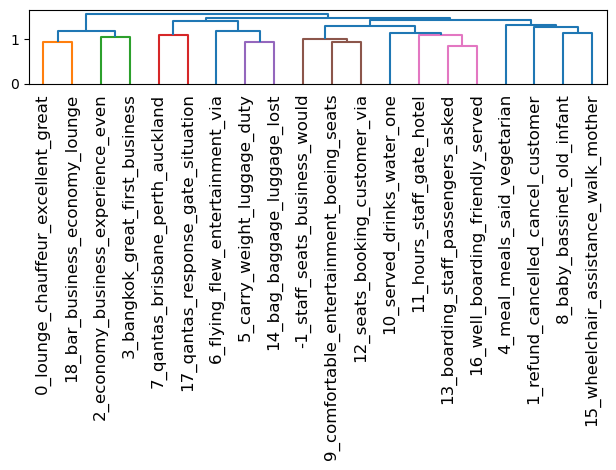

In [18]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

dendrogram = sch.dendrogram(sch.linkage(topic_embeddings, method='ward'), labels=topic_info["Name"].tolist(), leaf_rotation=90)
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd

# Example mapping you already have: ["Topic", "Name", "Cluster"]
# cluster_map_df = pd.DataFrame([...])

# --------------------------
cluster_map_df = pd.DataFrame({
    "Topic": [
        -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 
        9, 10, 11, 12, 13, 14, 15, 16, 17, 18
    ],
    "Name": [
        "-1_staff_seats_business_would",
        "0_lounge_chauffeur_excellent_great",
        "1_refund_cancelled_cancel_customer",
        "2_economy_business_experience_even",
        "3_bangkok_great_first_business",
        "4_meal_meals_said_vegetarian",
        "5_carry_weight_luggage_duty",
        "6_flying_flew_entertainment_via",
        "7_qantas_brisbane_perth_auckland",
        "8_baby_bassinet_old_infant",
        "9_comfortable_entertainment_boeing_seats",
        "10_served_drinks_water_one",
        "11_hours_staff_gate_hotel",
        "12_seats_booking_customer_via",
        "13_boarding_staff_passengers_asked",
        "14_bag_baggage_luggage_lost",
        "15_wheelchair_assistance_walk_mother",
        "16_well_boarding_friendly_served",
        "17_qantas_response_gate_situation",
        "18_bar_business_economy_lounge"
    ],
    "Cluster": [
        1, 2, 2, 3, 3, 4, 5, 0, 6, 1, 
        0, 7, 1, 1, 1, 5, 1, 1, 6, 3
    ]
})

cluster_groups = cluster_map_df.groupby("Cluster")["Topic"].apply(list).to_dict()

# --------------------------
# 2. Auto-generate cluster names
# --------------------------
def get_cluster_name(topics, topic_model, top_n=3):
    """Return cluster name by combining top_n keywords from its topics"""
    all_keywords = []
    for tid in topics:
        words = topic_model.get_topic(tid)
        if words:
            all_keywords.extend([w for w, _ in words])
    # Count frequency
    freq = pd.Series(all_keywords).value_counts()
    return "_".join(freq.head(top_n).index)

cluster_labels = {}
for cluster_id, topic_ids in cluster_groups.items():
    cluster_labels[cluster_id] = get_cluster_name(topic_ids, topic_model, top_n=3)

# --------------------------
# 3. Aggregate probabilities by cluster
# --------------------------
cluster_probs = {}
for cluster_id, topic_ids in cluster_groups.items():
    valid_ids = [i for i in topic_ids if i < probs.shape[1]]
    if valid_ids:
        col_name = f"topic_{cluster_labels[cluster_id]}"
        cluster_probs[col_name] = probs[:, valid_ids].sum(axis=1)

# --------------------------
# 4. Merge into em_df (or ba_df)
# --------------------------
cluster_probs_df = pd.DataFrame(cluster_probs)
em_df = pd.concat([em_df.reset_index(drop=True), cluster_probs_df], axis=1)

# --------------------------
# 5. Preview
# --------------------------
print(em_df[["review_text", "overall_rating"] + list(cluster_probs_df.columns)].head(5))


                                         review_text  overall_rating  \
0    Lately it's not enjoyable travelling economy...             5.0   
1    Our family booked together and having flown ...             1.0   
2    I took 4 flights with Emirates and it was an...             1.0   
3   Following up to my previous review ""worst cu...             1.0   
4   My luggage got damaged and I got information ...             2.0   

   topic_entertainment_via_great  topic_staff_would_get  \
0                   0.000000e+00           0.000000e+00   
1                   1.895613e-02           1.040940e-01   
2                   6.643972e-10           5.073256e-10   
3                   1.371198e-23           2.300527e-01   
4                   0.000000e+00           0.000000e+00   

   topic_lounge_chauffeur_covid  topic_business_economy_experience  \
0                  0.000000e+00                       1.000000e+00   
1                  2.167295e-02                       2.499315e-02   
2 

In [24]:
# Count nulls for all columns
em_df.isna().sum()

review_title                           0
review_date                            0
verified_flag                        142
aircraft                             464
travel_type                            0
                                    ... 
topic_business_economy_experience      0
topic_meal_meals_said                  0
topic_luggage_bag_baggage              0
topic_qantas_business_response         0
topic_served_drinks_water              0
Length: 77, dtype: int64

In [25]:
# List all column names
print(em_df.columns.tolist())

['review_title', 'review_date', 'verified_flag', 'aircraft', 'travel_type', 'travel_class', 'route', 'travel_date', 'seat_comfort', 'staff_service', 'food_quality', 'entertainment', 'wifi', 'ground_service', 'value_for_money', 'recommended', 'overall_rating', 'review_text', 'airline', 'origin', 'destination', 'origin_raw', 'stopover_raw', 'destination_raw', 'origin_coords', 'stopover_coords', 'destination_coords', 'distance_km', 'flight_category', 'review_text_clean', 'sentiment_label', 'sentiment_confidence', 'score_neg', 'score_neu', 'score_pos', 'sentiment_score', 'food_sentiment', 'seat_sentiment', 'staff_sentiment', 'baggage_sentiment', 'refunds_sentiment', 'lounge_sentiment', 'entertainment_sentiment', 'cleanliness_sentiment', 'airport_service_sentiment', 'anger', 'joy', 'optimism', 'sadness', 'clean_text', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topi

In [26]:
# Get all topic-related columns in em_df
topic_cols = [col for col in em_df.columns if col.startswith("topic_")]

print("Number of topic columns:", len(topic_cols))
print("Topic columns:", topic_cols)


Number of topic columns: 27
Topic columns: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_entertainment_via_great', 'topic_staff_would_get', 'topic_lounge_chauffeur_covid', 'topic_business_economy_experience', 'topic_meal_meals_said', 'topic_luggage_bag_baggage', 'topic_qantas_business_response', 'topic_served_drinks_water']


In [27]:
import pandas as pd

# Your manual mapping (Topic → Cluster)
cluster_map_df = pd.DataFrame({
    "Topic": [-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],
    "Name": [
        "-1_staff_seats_business_would",
        "0_lounge_chauffeur_excellent_great",
        "1_refund_cancelled_cancel_customer",
        "2_economy_business_experience_even",
        "3_bangkok_great_first_business",
        "4_meal_meals_said_vegetarian",
        "5_carry_weight_luggage_duty",
        "6_flying_flew_entertainment_via",
        "7_qantas_brisbane_perth_auckland",
        "8_baby_bassinet_old_infant",
        "9_comfortable_entertainment_boeing_seats",
        "10_served_drinks_water_one",
        "11_hours_staff_gate_hotel",
        "12_seats_booking_customer_via",
        "13_boarding_staff_passengers_asked",
        "14_bag_baggage_luggage_lost",
        "15_wheelchair_assistance_walk_mother",
        "16_well_boarding_friendly_served",
        "17_qantas_response_gate_situation",
        "18_bar_business_economy_lounge"
    ],
    "Cluster": [1,2,2,3,3,4,5,0,6,1,0,7,1,1,1,5,1,1,6,3]
})

# Group topics into clusters
cluster_groups = cluster_map_df.groupby("Cluster")["Topic"].apply(list).to_dict()

# Give names to clusters manually (or auto-name them if you prefer)
cluster_labels = {
    0: "entertainment",
    1: "staff_customer_seating",
    2: "refunds_lounge",
    3: "business_experience",
    4: "meals_food",
    5: "baggage",
    6: "qantas_related",
    7: "drinks_water"
}

# Build cluster probability columns
cluster_probs = {}
for cluster_id, topic_ids in cluster_groups.items():
    valid_cols = [f"topic_{tid}" for tid in topic_ids if f"topic_{tid}" in em_df.columns]
    if valid_cols:
        col_name = f"topic_{cluster_labels[cluster_id]}"
        cluster_probs[col_name] = em_df[valid_cols].sum(axis=1)

# Merge into em_df
cluster_probs_df = pd.DataFrame(cluster_probs)
em_df = pd.concat([em_df, cluster_probs_df], axis=1)

# Preview
print(em_df[["review_text", "overall_rating"] + list(cluster_probs_df.columns)].head(5))


                                         review_text  overall_rating  \
0    Lately it's not enjoyable travelling economy...             5.0   
1    Our family booked together and having flown ...             1.0   
2    I took 4 flights with Emirates and it was an...             1.0   
3   Following up to my previous review ""worst cu...             1.0   
4   My luggage got damaged and I got information ...             2.0   

   topic_entertainment  topic_staff_customer_seating  topic_refunds_lounge  \
0         0.000000e+00                  0.000000e+00          0.000000e+00   
1         1.895613e-02                  9.329719e-02          2.167295e-02   
2         6.643972e-10                  4.790382e-10          3.096056e-10   
3         1.371198e-23                  2.300527e-01          4.942743e-02   
4         0.000000e+00                  0.000000e+00          0.000000e+00   

   topic_business_experience  topic_meals_food  topic_baggage  \
0               1.000000e+00     

In [28]:
# Get all topic-related columns in em_df
topic_cols = [col for col in em_df.columns if col.startswith("topic_")]

print("Number of topic columns:", len(topic_cols))
print("Topic columns:", topic_cols)


Number of topic columns: 35
Topic columns: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_entertainment_via_great', 'topic_staff_would_get', 'topic_lounge_chauffeur_covid', 'topic_business_economy_experience', 'topic_meal_meals_said', 'topic_luggage_bag_baggage', 'topic_qantas_business_response', 'topic_served_drinks_water', 'topic_entertainment', 'topic_staff_customer_seating', 'topic_refunds_lounge', 'topic_business_experience', 'topic_meals_food', 'topic_baggage', 'topic_qantas_related', 'topic_drinks_water']


In [29]:
# List of topic columns you DON'T need anymore
drop_cols = [
    'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
    'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11',
    'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17',
    'topic_18', 'topic_entertainment_via_great', 'topic_staff_would_get',
    'topic_lounge_chauffeur_covid', 'topic_business_economy_experience',
    'topic_meal_meals_said', 'topic_luggage_bag_baggage',
    'topic_qantas_business_response', 'topic_served_drinks_water'
]

# Drop them if they exist
em_df = em_df.drop(columns=[c for c in drop_cols if c in em_df.columns])

# Check remaining topic columns
topic_cols = [c for c in em_df.columns if c.startswith("topic_")]
print(f"Remaining topic columns ({len(topic_cols)}): {topic_cols}")


Remaining topic columns (8): ['topic_entertainment', 'topic_staff_customer_seating', 'topic_refunds_lounge', 'topic_business_experience', 'topic_meals_food', 'topic_baggage', 'topic_qantas_related', 'topic_drinks_water']


In [30]:
# List all column names
print(em_df.columns.tolist())

['review_title', 'review_date', 'verified_flag', 'aircraft', 'travel_type', 'travel_class', 'route', 'travel_date', 'seat_comfort', 'staff_service', 'food_quality', 'entertainment', 'wifi', 'ground_service', 'value_for_money', 'recommended', 'overall_rating', 'review_text', 'airline', 'origin', 'destination', 'origin_raw', 'stopover_raw', 'destination_raw', 'origin_coords', 'stopover_coords', 'destination_coords', 'distance_km', 'flight_category', 'review_text_clean', 'sentiment_label', 'sentiment_confidence', 'score_neg', 'score_neu', 'score_pos', 'sentiment_score', 'food_sentiment', 'seat_sentiment', 'staff_sentiment', 'baggage_sentiment', 'refunds_sentiment', 'lounge_sentiment', 'entertainment_sentiment', 'cleanliness_sentiment', 'airport_service_sentiment', 'anger', 'joy', 'optimism', 'sadness', 'clean_text', 'topic_entertainment', 'topic_staff_customer_seating', 'topic_refunds_lounge', 'topic_business_experience', 'topic_meals_food', 'topic_baggage', 'topic_qantas_related', 'topic

In [33]:
aspect_cols = [
    'food_sentiment', 'seat_sentiment', 'staff_sentiment',
    'baggage_sentiment', 'refunds_sentiment', 'lounge_sentiment',
    'entertainment_sentiment', 'cleanliness_sentiment', 'airport_service_sentiment'
]

em_df[aspect_cols] = em_df[aspect_cols].fillna(0)


In [49]:
# Columns you want to keep

selected_cols1 = [
    'overall_rating', 'review_date', 'verified_flag', 'travel_type',
    'travel_class', 'seat_comfort', 'staff_service',
    'ground_service', 'value_for_money', 'recommended', 'food_quality','entertainment', 'wifi', 'flight_category',
    'sentiment_score','distance_km']
    
selected_cols = [
    'overall_rating', 'review_date', 'verified_flag', 'travel_type',
    'travel_class', 'seat_comfort', 'staff_service',
    'ground_service', 'value_for_money', 'recommended', 'food_quality',
    'entertainment', 'wifi', 'flight_category',
    'sentiment_score','distance_km', 'food_sentiment', 'seat_sentiment', 'staff_sentiment', 'baggage_sentiment', 'refunds_sentiment', 'lounge_sentiment', 'entertainment_sentiment', 'cleanliness_sentiment', 'airport_service_sentiment', 'anger', 'joy', 'optimism', 'sadness', 'clean_text', 'topic_entertainment', 'topic_staff_customer_seating', 'topic_refunds_lounge', 'topic_business_experience', 'topic_meals_food', 'topic_baggage', 'topic_qantas_related', 'topic_drinks_water'
]


# Create new DataFrames with only selected columns
ba_selected = ba_df[selected_cols1].copy()
em_selected = em_df[selected_cols].copy()

# Quick check
print("BA selected shape:", ba_selected.shape)
print("Emirates selected shape:", em_selected.shape)
print(ba_selected.head())

BA selected shape: (3217, 16)
Emirates selected shape: (1475, 38)
   overall_rating review_date  verified_flag     travel_type    travel_class  \
0             1.0  2023-11-19           True  Couple Leisure   Economy Class   
1             3.0  2023-11-19           True        Business   Economy Class   
2             8.0  2023-11-16          False  Couple Leisure  Business Class   
3             1.0  2023-11-16           True  Couple Leisure   Economy Class   
4             1.0  2023-11-14          False  Couple Leisure   Economy Class   

   seat_comfort  staff_service  ground_service  value_for_money recommended  \
0           1.0            1.0             1.0                1          no   
1           2.0            3.0             1.0                2          no   
2           3.0            3.0             4.0                3         yes   
3           3.0            3.0             1.0                1          no   
4           1.0            1.0             1.0            

In [50]:
# Check data types for the selected columns
print("British Airways selected columns info:")
print(ba_selected.dtypes)

print("\nEmirates selected columns info:")
print(em_selected.dtypes)

British Airways selected columns info:
overall_rating     float64
review_date         object
verified_flag         bool
travel_type         object
travel_class        object
seat_comfort       float64
staff_service      float64
ground_service     float64
value_for_money      int64
recommended         object
food_quality       float64
entertainment      float64
wifi               float64
flight_category     object
sentiment_score    float64
distance_km        float64
dtype: object

Emirates selected columns info:
overall_rating                  float64
review_date                      object
verified_flag                    object
travel_type                      object
travel_class                     object
seat_comfort                    float64
staff_service                   float64
ground_service                  float64
value_for_money                   int64
recommended                      object
food_quality                    float64
entertainment                   float64
wi

In [51]:
# Count nulls for all columns
em_df.isna().sum()

review_title                      0
review_date                       0
verified_flag                   142
aircraft                        464
travel_type                       0
travel_class                      0
route                             0
travel_date                       0
seat_comfort                     59
staff_service                    60
food_quality                    115
entertainment                   151
wifi                            579
ground_service                   37
value_for_money                   0
recommended                       0
overall_rating                    0
review_text                       0
airline                           0
origin                            2
destination                       2
origin_raw                        2
stopover_raw                    625
destination_raw                   2
origin_coords                     2
stopover_coords                 625
destination_coords                2
distance_km                 

# Data Preprocessing & Cleaning

In [52]:
# Convert review_date to datetime for both datasets
ba_selected["review_date"] = pd.to_datetime(ba_selected["review_date"], errors="coerce")
em_selected["review_date"] = pd.to_datetime(em_selected["review_date"], errors="coerce")

# Quick check
print(ba_selected["review_date"].head())
print(em_selected["review_date"].head())

0   2023-11-19
1   2023-11-19
2   2023-11-16
3   2023-11-16
4   2023-11-14
Name: review_date, dtype: datetime64[ns]
0   2023-12-31
1   2023-12-26
2   2023-12-25
3   2023-12-22
4   2023-12-22
Name: review_date, dtype: datetime64[ns]


In [53]:
print("BA review_date dtype:", ba_selected['review_date'].dtype)
print("Emirates review_date dtype:", em_selected['review_date'].dtype)

BA review_date dtype: datetime64[ns]
Emirates review_date dtype: datetime64[ns]


In [54]:
# Median imputation for both BA and Emirates
ba_selected['overall_rating'] = ba_selected['overall_rating'].fillna(ba_selected['overall_rating'].median())

- ## Travel Class

In [55]:
# Step 1: Standardize casing/spacing
ba_selected['travel_class'] = ba_selected['travel_class'].str.strip().str.title()
em_selected['travel_class'] = em_selected['travel_class'].str.strip().str.title()

# Step 2: Manual mapping for synonyms/misspellings (example)
map_classes = {
    "Eco": "Economy",
    "Economy Class": "Economy",
    "Premiun Economy": "Premium Economy",
    "Premium": "Premium Economy",
    "Biz": "Business",
    "Business Class": "Business",
    "First Class": "First"
}
ba_selected['travel_class'] = ba_selected['travel_class'].replace(map_classes)
em_selected['travel_class'] = em_selected['travel_class'].replace(map_classes)

# Step 3: Ordinal mapping
ordinal_map = {
    "Economy": 1,
    "Premium Economy": 2,
    "Business": 3,
    "First": 4
}
ba_selected['travel_class'] = ba_selected['travel_class'].map(ordinal_map)
em_selected['travel_class'] = em_selected['travel_class'].map(ordinal_map)

# Step 4: Impute BA missing with mode
ba_selected['travel_class'] = ba_selected['travel_class'].fillna(ba_selected['travel_class'].mode()[0])

# Force both to integer dtype
ba_selected['travel_class'] = ba_selected['travel_class'].astype(int)
em_selected['travel_class'] = em_selected['travel_class'].astype(int)

# Check results
print("Unique values in BA travel_class:", ba_selected['travel_class'].unique())
print("Unique values in Emirates travel_class:", em_selected['travel_class'].unique())
print("\nMissing in BA travel_class:", ba_selected['travel_class'].isna().sum())
print("Missing in Emirates travel_class:", em_selected['travel_class'].isna().sum())

Unique values in BA travel_class: [1 3 2 4]
Unique values in Emirates travel_class: [1 3 4 2]

Missing in BA travel_class: 0
Missing in Emirates travel_class: 0


- ## Travel Type

In [56]:
# Step 1: Standardize casing and spacing
ba_selected['travel_type'] = ba_selected['travel_type'].str.strip().str.title()
em_selected['travel_type'] = em_selected['travel_type'].str.strip().str.title()

# Step 2: Create missingness flag
ba_selected['travel_type_missing'] = ba_selected['travel_type'].isna().astype(int)
em_selected['travel_type_missing'] = em_selected['travel_type'].isna().astype(int)

# Step 3: Map to simplified categories
map_types = {
    "Business": "Business",
    "Solo Leisure": "Solo",
    "Couple Leisure": "Couple",
    "Family Leisure": "Family"
}
ba_selected['travel_type'] = ba_selected['travel_type'].replace(map_types)
em_selected['travel_type'] = em_selected['travel_type'].replace(map_types)

# Step 4: Fill NaN with 'Unknown'
ba_selected['travel_type'] = ba_selected['travel_type'].fillna('Unknown')
em_selected['travel_type'] = em_selected['travel_type'].fillna('Unknown')

# Step 5: One-hot encode
ba_selected = pd.get_dummies(ba_selected, columns=['travel_type'], prefix='type')
em_selected = pd.get_dummies(em_selected, columns=['travel_type'], prefix='type')

# Step 6: Align one-hot columns between BA and Emirates
all_travel_type_cols = sorted(set(ba_selected.filter(like='type_').columns)
                              .union(set(em_selected.filter(like='type_').columns)))

for col in all_travel_type_cols:
    if col not in ba_selected:
        ba_selected[col] = False
    if col not in em_selected:
        em_selected[col] = False

ba_selected = ba_selected.reindex(columns=[c for c in ba_selected.columns if c not in all_travel_type_cols] + all_travel_type_cols)
em_selected = em_selected.reindex(columns=[c for c in em_selected.columns if c not in all_travel_type_cols] + all_travel_type_cols)

# Step 7: Check alignment
print("BA travel_type columns:", ba_selected.filter(like='type_').columns.tolist())
print("Emirates travel_type columns:", em_selected.filter(like='type_').columns.tolist())

BA travel_type columns: ['travel_type_missing', 'type_Business', 'type_Couple', 'type_Family', 'type_Solo', 'type_Unknown']
Emirates travel_type columns: ['travel_type_missing', 'type_Business', 'type_Couple', 'type_Family', 'type_Solo', 'type_Unknown']


- ## Verified Flag

In [57]:
# Step 1: BA clean boolean to text
ba_selected['verified_flag'] = ba_selected['verified_flag'].map({True: "Verified", False: "Not Verified"})

# Step 2: Emirates messy strings to clean categories
def clean_verified(value):
    if pd.isna(value):
        return "Unknown"
    val = str(value).strip().lower()
    if "trip verified" in val or "verified review" in val:
        return "Verified"
    elif "not verified" in val:
        return "Not Verified"
    else:
        return "Unknown"

em_selected['verified_flag'] = em_selected['verified_flag'].apply(clean_verified)

# Step 3: Ensure same categories
valid_categories = ["Unknown", "Not Verified", "Verified"]

ba_selected['verified_flag'] = pd.Categorical(ba_selected['verified_flag'], categories=valid_categories, ordered=True)
em_selected['verified_flag'] = pd.Categorical(em_selected['verified_flag'], categories=valid_categories, ordered=True)

# Step 4: Ordinal encoding
ordinal_map = {"Unknown": 0, "Not Verified": 1, "Verified": 2}
ba_selected['verified_flag'] = ba_selected['verified_flag'].map(ordinal_map).astype(int)
em_selected['verified_flag'] = em_selected['verified_flag'].map(ordinal_map).astype(int)

# Step 5: Check
print("BA verified_flag unique values:", ba_selected['verified_flag'].unique())
print("Emirates verified_flag unique values:", em_selected['verified_flag'].unique())

BA verified_flag unique values: [2 1]
Emirates verified_flag unique values: [2 1 0]


- ## Staff Service & Seat Comfort

In [58]:
# Airline + travel_class median imputation
for col in ['staff_service', 'seat_comfort']:
    ba_selected[col] = ba_selected.groupby('travel_class')[col] \
                                  .transform(lambda x: x.fillna(x.median()))
    em_selected[col] = em_selected.groupby('travel_class')[col] \
                                  .transform(lambda x: x.fillna(x.median()))

# Ensure integer dtype
ba_selected[['staff_service', 'seat_comfort']] = ba_selected[['staff_service', 'seat_comfort']].astype(int)
em_selected[['staff_service', 'seat_comfort']] = em_selected[['staff_service', 'seat_comfort']].astype(int)

# Check if any nulls remain
print("BA nulls remaining:", ba_selected[['staff_service', 'seat_comfort']].isna().sum().to_dict())
print("Emirates nulls remaining:", em_selected[['staff_service', 'seat_comfort']].isna().sum().to_dict())


BA nulls remaining: {'staff_service': 0, 'seat_comfort': 0}
Emirates nulls remaining: {'staff_service': 0, 'seat_comfort': 0}


- ## Recommended

In [59]:
# Map yes/no to 1/0
ba_selected['recommended'] = ba_selected['recommended'].str.strip().str.lower().map({'yes': 1, 'no': 0}).astype(int)
em_selected['recommended'] = em_selected['recommended'].str.strip().str.lower().map({'yes': 1, 'no': 0}).astype(int)

- ## Flight Category

In [60]:
# Map flight_category to ordinal values
category_map = {"Unknown": 0, "Short-haul": 1, "Medium-haul": 2, "Long-haul": 3}
ba_selected['flight_category'] = ba_selected['flight_category'].map(category_map).astype(int)
em_selected['flight_category'] = em_selected['flight_category'].map(category_map).astype(int)

# Display first 3 rows
print("BA sample:")
print(ba_selected.head(3))

print("\nEmirates sample:")
print(em_selected.head(3))

BA sample:
   overall_rating review_date  verified_flag  travel_class  seat_comfort  \
0             1.0  2023-11-19              2             1             1   
1             3.0  2023-11-19              2             1             2   
2             8.0  2023-11-16              1             3             3   

   staff_service  ground_service  value_for_money  recommended  food_quality  \
0              1             1.0                1            0           NaN   
1              3             1.0                2            0           1.0   
2              3             4.0                3            1           4.0   

   ...  wifi  flight_category  sentiment_score  distance_km  \
0  ...   NaN                1         1.383938   754.968413   
1  ...   2.0                1         1.379170   350.050442   
2  ...   NaN                1         8.491750   449.275680   

   travel_type_missing  type_Business  type_Couple  type_Family  type_Solo  \
0                    0          

- ## Value for Money

In [61]:
# Median imputation for value_for_money
ba_selected['value_for_money'] = ba_selected['value_for_money'].fillna(ba_selected['value_for_money'].median())
em_selected['value_for_money'] = em_selected['value_for_money'].fillna(em_selected['value_for_money'].median())

# Ensure integer dtype
ba_selected['value_for_money'] = ba_selected['value_for_money'].astype(int)
em_selected['value_for_money'] = em_selected['value_for_money'].astype(int)

In [62]:
print("BA columns and data types:")
print(ba_selected.dtypes)

print("\nEmirates columns and data types:")
print(em_selected.dtypes)

BA columns and data types:
overall_rating                float64
review_date            datetime64[ns]
verified_flag                   int32
travel_class                    int32
seat_comfort                    int32
staff_service                   int32
ground_service                float64
value_for_money                 int32
recommended                     int32
food_quality                  float64
entertainment                 float64
wifi                          float64
flight_category                 int32
sentiment_score               float64
distance_km                   float64
travel_type_missing             int32
type_Business                    bool
type_Couple                      bool
type_Family                      bool
type_Solo                        bool
type_Unknown                     bool
dtype: object

Emirates columns and data types:
overall_rating                         float64
review_date                     datetime64[ns]
verified_flag                    

# Missing Flag

- ## Food Quality Missing Flag

In [63]:
# BA
ba_selected['food_quality_missing'] = ba_selected['food_quality'].isna().astype(int)

# Emirates
em_selected['food_quality_missing'] = em_selected['food_quality'].isna().astype(int)

# Check
print("BA missing flag counts:\n", ba_selected['food_quality_missing'].value_counts())
print("\nEmirates missing flag counts:\n", em_selected['food_quality_missing'].value_counts())

BA missing flag counts:
 food_quality_missing
0    2832
1     385
Name: count, dtype: int64

Emirates missing flag counts:
 food_quality_missing
0    1360
1     115
Name: count, dtype: int64


- ## Wifi Missing Flag

In [64]:
# BA
ba_selected['wifi_missing'] = ba_selected['wifi'].isna().astype(int)
ba_selected = ba_selected.rename(columns={'wifi': 'wifi_score'})

# Emirates
em_selected['wifi_missing'] = em_selected['wifi'].isna().astype(int)
em_selected = em_selected.rename(columns={'wifi': 'wifi_score'})

- ## Entertainment Missing Flag

In [65]:
# BA
ba_selected['entertainment_missing'] = ba_selected['entertainment'].isna().astype(int)
ba_selected = ba_selected.rename(columns={'entertainment': 'entertainment_score'})

# Emirates
em_selected['entertainment_missing'] = em_selected['entertainment'].isna().astype(int)
em_selected = em_selected.rename(columns={'entertainment': 'entertainment_score'})

- ## Ground Service Missing Flag

In [66]:
# Step 1: Create missingness flag
ba_selected['ground_service_missing'] = ba_selected['ground_service'].isna().astype(int)
em_selected['ground_service_missing'] = em_selected['ground_service'].isna().astype(int)

# Step 4: Check
print("BA missing flag counts:", ba_selected['ground_service_missing'].value_counts())
print("Emirates missing flag counts:", em_selected['ground_service_missing'].value_counts())

BA missing flag counts: ground_service_missing
0    2855
1     362
Name: count, dtype: int64
Emirates missing flag counts: ground_service_missing
0    1438
1      37
Name: count, dtype: int64


In [67]:
print("BA columns and data types:")
print(ba_selected.dtypes)

print("\nEmirates columns and data types:")
print(em_selected.dtypes)

BA columns and data types:
overall_rating                   float64
review_date               datetime64[ns]
verified_flag                      int32
travel_class                       int32
seat_comfort                       int32
staff_service                      int32
ground_service                   float64
value_for_money                    int32
recommended                        int32
food_quality                     float64
entertainment_score              float64
wifi_score                       float64
flight_category                    int32
sentiment_score                  float64
distance_km                      float64
travel_type_missing                int32
type_Business                       bool
type_Couple                         bool
type_Family                         bool
type_Solo                           bool
type_Unknown                        bool
food_quality_missing               int32
wifi_missing                       int32
entertainment_missing         

# Imputing Ground_Service ,Wifi, Food quality, Entertainment

In [72]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

# --- WIFI ---
# Median per travel_class
em_df['wifi_score'] = em_df.groupby('travel_class')['wifi_score']\
                           .transform(lambda x: x.fillna(x.median()))

# --- Ground Service ---
simple_imputer = SimpleImputer(strategy="median")
em_df[['ground_service']] = simple_imputer.fit_transform(em_df[['ground_service']])

# --- Food Quality ---
em_df['food_quality'] = em_df.groupby('travel_class')['food_quality']\
                             .transform(lambda x: x.fillna(x.median()))

# --- Entertainment ---
features_for_knn_ent_em = ['entertainment_score', 'travel_class', 'distance_km']
knn_imputer_ent_em = KNNImputer(n_neighbors=5)
imputed_ent_em = knn_imputer_ent_em.fit_transform(em_df[features_for_knn_ent_em])
em_df['entertainment_score'] = imputed_ent_em[:, 0]


# =====================
# Check Remaining Missingness
# =====================
print("=== Missingness in British Airways ===")
print(ba_df.isna().sum()[ba_df.isna().sum() > 0])

print("\n=== Missingness in Emirates ===")
print(em_df.isna().sum()[em_df.isna().sum() > 0])

=== Missingness in British Airways ===
distance_km    294
dtype: int64

=== Missingness in Emirates ===
distance_km    2
dtype: int64


In [77]:
# Save Emirates processed dataset
em_df.to_csv(r"C:\Users\Samiksha\Downloads\Emirates_1Newcsv", index=False)

print("Files saved to Downloads folder.")

Files saved to Downloads folder.
